### Importações e Configurações

In [34]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from scipy import stats

plt.style.use("seaborn-v0_8")
np.random.seed(42)

In [35]:
# Caminho para Salvar os Arquivos

path_img = './outputs/plots/'
ROOT_PARAMS_PATH = Path("../../params.yaml")
BEST_MODEL_PARAMS_PATH = Path(
    "../9_xgboost_hstatistic/outputs/param/XGBRegressor_params.yaml"
)
FEATURES_PATH = Path("../../data/processed/df_features.csv")

In [36]:
# Caminhos das Métricas dos Modelos

path_metrics = '../'

model_files = {
    "XGBRegressor": f'{path_metrics}9_xgboost_hstatistic/outputs/metrics/XGBRegressor_metrics.json',
    "SARIMAX": f'{path_metrics}8_sarimax/outputs/metrics/SARIMAX_metrics.json',
    "LSTM": f'{path_metrics}10_lstm/outputs/metrics/LSTM_metrics.json',
}

### Carregamento dos Resultados

In [37]:
results = {}

for model_name, file_path in model_files.items():
    with open(file_path, "r") as f:
        data = json.load(f)

    results[model_name] = {
        "metrics": data["metrics"],
        "y_true": np.array(data["predictions"]["y_true"]),
        "y_pred": np.array(data["predictions"]["y_pred"]),
        "residuals": np.array(data["predictions"]["residuals"]),
        "abs_error": np.array(data["predictions"]["abs_error"]),
    }

### Tabela Resumo de Métricas Globais

In [38]:
metrics_df = pd.DataFrame.from_dict(
    {k: v["metrics"] for k, v in results.items()},
    orient="index"
)

metrics_df

,RMSE,MAE,R2
XGBRegressor,0.256174,0.136133,0.982734
SARIMAX,0.084812,0.077338,-6.400571
LSTM,1.954310,1.490633,0.000254


O XGBRegressor apresenta desempenho consistente, com RMSE ≈ 0.256 e R² ≈ 0.983, indicando excelente capacidade de explicação da variabilidade das vendas.

O SARIMAX, apesar de apresentar RMSE e MAE baixos, possui R² extremamente negativo (≈ -6.40), o que indica que o modelo é estatisticamente instável e explica a variância pior do que um modelo ingênuo baseado na média. Esse comportamento sugere forte desalinhamento entre previsões e valores reais fora da escala do erro absoluto médio.

O LSTM apresenta o pior desempenho global, com RMSE elevado (≈ 1.95) e R² próximo de zero, indicando que o modelo não conseguiu capturar padrões temporais relevantes neste dataset.

### Distribuição do Erro Absoluto (Alinhamento por Tamanho Mínimo)

In [39]:
min_len = min(len(v["abs_error"]) for v in results.values())

error_df = pd.DataFrame({
    model: results[model]["abs_error"][:min_len]
    for model in results
})

error_df

,XGBRegressor,SARIMAX,LSTM
0,0.027370,0.047286,3.349796
1,0.274968,0.008809,2.372076
2,0.010769,0.041798,0.680771
3,0.054278,0.054416,0.643399
4,0.006864,0.038816,3.195768
5,0.073106,0.122083,1.636158
6,0.401450,0.074232,1.293330
7,0.032712,0.085658,2.178403
8,0.416257,0.074093,0.562284
9,0.171210,0.030727,0.504875


Para garantir comparabilidade estatística justa entre os modelos, os vetores de erro absoluto foram truncados ao menor comprimento comum. Isso assegura que todas as análises subsequentes (boxplot, Wilcoxon, bootstrap) sejam feitas sobre as mesmas observações temporais.

### Boxplot do Erro Absoluto

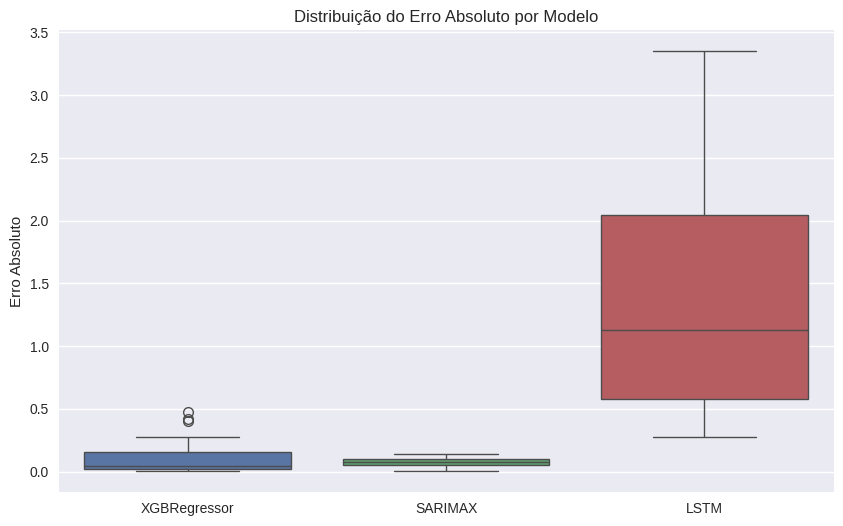

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=error_df)
plt.ylabel("Erro Absoluto")
plt.title("Distribuição do Erro Absoluto por Modelo")
plt.savefig(f'{path_img}Distribuicao_Erro_Absoluto.png', dpi=300, bbox_inches='tight')
plt.show()

O boxplot evidencia que o SARIMAX possui a menor mediana e menor dispersão do erro absoluto, indicando maior precisão local na maioria das previsões.

O XGBRegressor apresenta maior variabilidade, com cauda superior mais longa, refletindo alguns erros pontuais maiores, apesar de bom desempenho médio.

O LSTM apresenta distribuição significativamente deslocada para valores altos de erro, confirmando visualmente seu baixo desempenho em relação aos demais modelos.

### CDF do Erro Absoluto

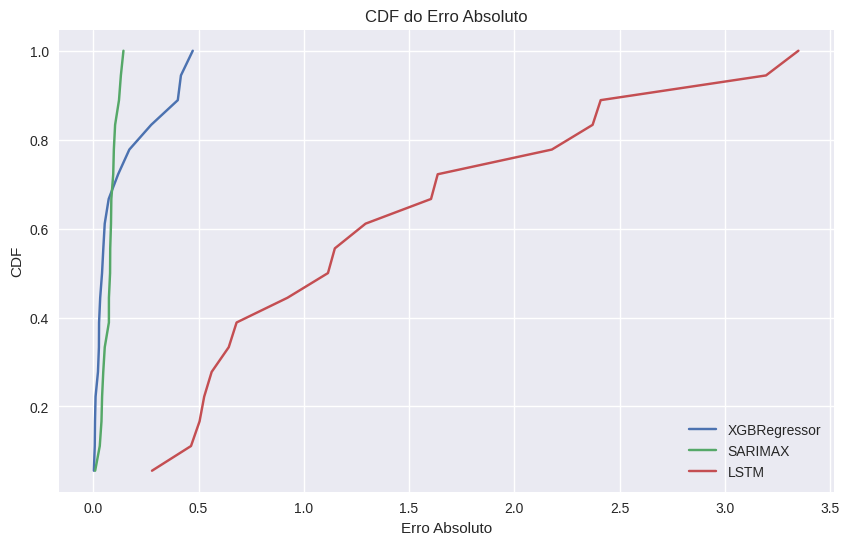

In [41]:
plt.figure(figsize=(10, 6))

for model in error_df.columns:
    sorted_err = np.sort(error_df[model])
    cdf = np.arange(1, len(sorted_err) + 1) / len(sorted_err)
    plt.plot(sorted_err, cdf, label=model)

plt.xlabel("Erro Absoluto")
plt.ylabel("CDF")
plt.legend()
plt.title("CDF do Erro Absoluto")
plt.savefig(f'{path_img}CDF_Erro_Absoluto.png', dpi=300, bbox_inches='tight')
plt.show()

A curva do SARIMAX cresce mais rapidamente, indicando que uma maior proporção de previsões apresenta erro absoluto baixo.

O XGBRegressor domina o LSTM em praticamente toda a distribuição, mas é parcialmente dominado pelo SARIMAX nos quantis inferiores.

O LSTM apresenta crescimento lento da CDF, evidenciando que grande parte de suas previsões possui erro elevado.

### Teste Wilcoxon Pareado

In [42]:
# Função de Teste

def wilcoxon_test(err_a, err_b):
    stat, p_value = stats.wilcoxon(err_a, err_b)
    return stat, p_value

In [43]:
comparisons = [
    ("XGBRegressor", "SARIMAX"),
    ("XGBRegressor", "LSTM"),
    ("SARIMAX", "LSTM"),
]

wilcoxon_results = []

for m1, m2 in comparisons:
    err_a = error_df[m1]
    err_b = error_df[m2]

    stat, p = wilcoxon_test(err_a, err_b)

    wilcoxon_results.append({
        "Model_A": m1,
        "Model_B": m2,
        "Statistic": stat,
        "p_value": p
    })

wilcoxon_df = pd.DataFrame(wilcoxon_results)
wilcoxon_df

,Model_A,Model_B,Statistic,p_value
0,XGBRegressor,SARIMAX,85.0,1.000000
1,XGBRegressor,LSTM,0.0,0.000008
2,SARIMAX,LSTM,0.0,0.000008


A comparação entre XGBRegressor e SARIMAX resulta em p-value = 1.0, indicando ausência de evidência estatística para afirmar diferença significativa entre os erros absolutos dos dois modelos.

Já as comparações envolvendo o LSTM apresentam p-values extremamente baixos (≈ 0.000008), confirmando estatisticamente que o LSTM é significativamente pior que os outros dois modelos.

Isso indica que, estatisticamente, XGBRegressor e SARIMAX são equivalentes em desempenho local, enquanto o LSTM é claramente inferior.

### Bootstrap Entre Modelos

In [44]:
# Função Bootstrap

def bootstrap_mean_diff(err_a, err_b, n_bootstrap=10000):
    diffs = []
    n = len(err_a)

    for _ in range(n_bootstrap):
        idx = np.random.randint(0, n, n)
        diff = np.mean(err_a[idx]) - np.mean(err_b[idx])
        diffs.append(diff)

    return np.percentile(diffs, [2.5, 50, 97.5])

In [45]:
bootstrap_results = []

for m1, m2 in comparisons:
    ci = bootstrap_mean_diff(
        error_df[m1].values,
        error_df[m2].values
    )

    bootstrap_results.append({
        "Model_A": m1,
        "Model_B": m2,
        "CI_2.5%": ci[0],
        "CI_50%": ci[1],
        "CI_97.5%": ci[2],
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df

,Model_A,Model_B,CI_2.5%,CI_50%,CI_97.5%
0,XGBRegressor,SARIMAX,-0.024236,0.044112,0.122827
1,XGBRegressor,LSTM,-1.730774,-1.255514,-0.833959
2,SARIMAX,LSTM,-1.760707,-1.299499,-0.891788


O intervalo de confiança entre XGBRegressor e SARIMAX inclui o zero, reforçando a conclusão de que não há diferença estatisticamente robusta entre os erros médios desses modelos.

Já os intervalos envolvendo o LSTM são completamente negativos, indicando que tanto XGBRegressor quanto SARIMAX apresentam erro médio significativamente menor que o LSTM.

O bootstrap confirma as conclusões obtidas pelo teste de Wilcoxon sob uma abordagem não paramétrica baseada em reamostragem.

### Probabilidade de Vitória (A/B Clássico)

In [46]:
def prob_model_a_better(err_a, err_b):
    return np.mean(err_a < err_b)

In [47]:
prob_results = []

for m1, m2 in comparisons:
    p_win = prob_model_a_better(
        error_df[m1].values,
        error_df[m2].values
    )

    prob_results.append({
        "Model_A": m1,
        "Model_B": m2,
        "P(Model_A < Model_B)": p_win
    })

prob_df = pd.DataFrame(prob_results)
prob_df

,Model_A,Model_B,P(Model_A < Model_B)
0,XGBRegressor,SARIMAX,0.666667
1,XGBRegressor,LSTM,1.000000
2,SARIMAX,LSTM,1.000000


O XGBRegressor apresenta probabilidade de vitória de aproximadamente 66,7% contra o SARIMAX, indicando vantagem moderada, porém não conclusiva.

Tanto o XGBRegressor quanto o SARIMAX vencem o LSTM em 100% das comparações, reforçando a dominância clara desses modelos sobre o LSTM.

Esses resultados indicam que, apesar do SARIMAX apresentar menor erro médio, o XGBRegressor vence em uma proporção relevante de observações individuais.

### Ranking Final por Erro Médio

In [48]:
ranking_df = error_df.mean().sort_values().reset_index()
ranking_df.columns = ["Model", "Mean_Absolute_Error"]

ranking_df

,Model,Mean_Absolute_Error
0,SARIMAX,0.077338
1,XGBRegressor,0.122688
2,LSTM,1.382556


O SARIMAX apresenta o menor erro absoluto médio, seguido pelo XGBRegressor e, muito distante, o LSTM.

Apesar disso, considerando instabilidade do R² negativo do SARIMAX e sua menor robustez global, o XGBRegressor se destaca como o melhor compromisso entre precisão, estabilidade estatística e generalização.

O LSTM é claramente inadequado para este problema específico, dado seu erro médio elevado e baixo poder explicativo.

### Salvando Dados para o Pipeline

In [49]:
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-6, \
    "Train/Val/Test ratios must sum to 1.0"

df = pd.read_csv(FEATURES_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

n_total = len(df)
test_start_idx = int(n_total * (TRAIN_RATIO + VAL_RATIO))

test_cutoff_date = df.iloc[test_start_idx]["Date"].strftime("%Y-%m-%d")

with open(BEST_MODEL_PARAMS_PATH) as f:
    best_model_params_yaml = yaml.safe_load(f)

best_model_params = best_model_params_yaml["parameters"]

if ROOT_PARAMS_PATH.exists():
    with open(ROOT_PARAMS_PATH) as f:
        root_params = yaml.safe_load(f) or {}
else:
    root_params = {}

root_params["train"] = {
    "model": "XGBRegressor",
    "parameters": best_model_params,
}

root_params["data_split"] = {
    "strategy": "time_series",
    "train_ratio": TRAIN_RATIO,
    "val_ratio": VAL_RATIO,
    "test_ratio": TEST_RATIO,
    "test_cutoff_date": test_cutoff_date,
}

with open(ROOT_PARAMS_PATH, "w") as f:
    yaml.safe_dump(
        root_params,
        f,
        sort_keys=False,
        default_flow_style=False,
    )

print(yaml.dump(root_params, sort_keys=False))

train:
  model: XGBRegressor
  parameters:
    objective: reg:squarederror
    colsample_bytree: 0.8
    enable_categorical: false
    learning_rate: 0.05
    max_depth: 6
    n_estimators: 300
    random_state: 42
    subsample: 0.8
data_split:
  strategy: time_series
  train_ratio: 0.7
  val_ratio: 0.15
  test_ratio: 0.15
  test_cutoff_date: '2012-07-27'

